#Connect to spotify API

In [ ]:
pip install spotipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.6/255.6 kB 10.2 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd

import time

In [ ]:
client_id = '###'
client_secret = '###'
redirect_uri = 'https://www.spotify.com/us/account/'

In [ ]:
# Set up the authentication
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

#Store Kaggle data ISRC values in a list

In [ ]:
#read Kaggle Music streaming data and store in DF
streaming_df = pd.read_csv('/content/MostStreamedSpotify_2024.csv', encoding='ISO-8859-1')

# start at [:500] and increment up by 500 values at a time.
#Next would be [500:1000] and go up to [4000:4600] to parse through all streaming data IRSC values
#set increment then run block below to retrieve spotify API data with those 500 IRSC values
isrc_list = streaming_df['ISRC'].tolist()[:500]

# Initialize an empty list to store merged rows
merged_data = []


#Iterate through the ISRC list 500 values at a time

Create the dataset scraped from Spotify's API using the IRSC values to fetch the Spotify songs with that same IRSC number

In [ ]:


# Function to search for tracks by ISRC and fetch relevant track data

#IMPORTANT: go to last line in this chunck and change the name of the CSV file to be saved as you run through
#           each increment of the ISRC values. Important to do so so that the new data does not override previous
def get_tracks_by_isrc(isrc_list):
    track_data = []

    for isrc in isrc_list:
        try:
            # Search for track using ISRC
            result = sp.search(q=f'isrc:{isrc}', type='track', limit=1)

            if result['tracks']['items']:
                song = result['tracks']['items'][0]
                track_info = {
                    'track_id': song['id'],
                    'track_name': song['name'],
                    'album_name': song['album']['name'],
                    'artist_name': song['artists'][0]['name'],
                    'release_date': song['album']['release_date'],
                    'popularity': song['popularity'],
                    'isrc': song['external_ids'].get('isrc')
                }
                track_data.append(track_info)

            time.sleep(0.1)

        except spotipy.exceptions.SpotifyException as e:
            print(f"Spotify API error: {e}")
            time.sleep(1)  # Retry delay in case of an error

    return track_data

# Fetch track data for the first 500 ISRC values
tracks_from_isrc = get_tracks_by_isrc(isrc_list)

# Convert the track data to a DataFrame
track_df = pd.DataFrame(tracks_from_isrc)

# Get track IDs for the retrieved songs
track_ids = track_df['track_id'].tolist()

# Function to fetch audio features for the track IDs
def get_audio_features(track_ids):
    audio_features = []
    for i in range(0, len(track_ids), 100):  # Spotify allows up to 100 tracks per request
        features = sp.audio_features(track_ids[i:i+100])
        audio_features.extend(features)
        time.sleep(1)
    return audio_features

# Fetch audio features for the retrieved songs
audio_features = get_audio_features(track_ids)

# Convert audio features to a DataFrame
audio_features_df = pd.DataFrame(audio_features)

# Merge the track information with the audio features on track_id
final_df = pd.merge(track_df, audio_features_df, left_on='track_id', right_on='id')

# Display the final DataFrame including both track info and audio features
print(final_df)

#Save the final data to a CSV
#each time same the spotify_# to a dirrerent number so that all 500 data frames can be joined below
final_df.to_csv('spotify_9.csv', index=False)


#Combine Spotify API files

In [ ]:
# List of CSV file paths
csv_files = ['spotify_1.csv', 'spotify_2.csv',
             'spotify_3.csv', 'spotify_4.csv',
             'spotify_5.csv', 'spotify_6.csv',
             'spotify_7.csv', 'spotify_8.csv',
             'spotify_9.csv']

# Read each CSV into a DataFrame and store them in a list
df_list = [pd.read_csv(file) for file in csv_files]

# Use pd.concat() to row bind (concatenate) all DataFrames
combined_spotify_df = pd.concat(df_list, axis=0, ignore_index=True)

# Display the combined DataFrame
print(combined_spotify_df)

# Optionally save the final data to a CSV
combined_spotify_df.to_csv('combined_spotify_df.csv', index=False)

                    track_id                       track_name  \
0     5AJ9hqTS2wcFQCELCFRO7A              MILLION DOLLAR BABY   
1     6AI3ezQ4o3HUoP6Dhudph3                      Not Like Us   
2     2GxrNKugF82CnoRFbQfzPf       i like the way you kiss me   
3     7DSAEUvxU8FajXtRloy8M0                          Flowers   
4     2HYFX63wP3otVIvopRS99Z                          Houdini   
...                      ...                              ...   
4420  240audWazVjwvwh7XwfSZE                For the Last Time   
4421  4ILc7H2NfGbzbrHBclNOtB                 Dil Meri Na Sune   
4422  01JMnRUs2YOK6DDpdQASGY            Grace (feat. 42 Dugg)   
4423  0biCSADTAblvLTLtJz4pXO              Nashe Si Chadh Gayi   
4424  2FIm6YsSGL5acOqSuJDh5s  Me Acostumbre (feat. Bad Bunny)   

                                       album_name     artist_name  \
0                             MILLION DOLLAR BABY   Tommy Richman   
1                                     Not Like Us  Kendrick Lamar   
2           

#Join The Streaming data to spotify API data

In [ ]:
# Ensure the 'ISRC' in streaming data and 'isrc' in Spotify API data are in the same case
streaming_df['ISRC'] = streaming_df['ISRC'].str.upper()
combined_spotify_df['isrc'] = combined_spotify_df['isrc'].str.upper()

# Perform a merge on the 'ISRC' and 'isrc' columns
merged_df = pd.merge(streaming_df, combined_spotify_df, left_on='ISRC', right_on='isrc', how='inner')


print(merged_df)

# save as csv
merged_df.to_csv('merged_streaming_spotify_data.csv', index=False)


                                Track                        Album Name  \
0                 MILLION DOLLAR BABY      Million Dollar Baby - Single   
1                         Not Like Us                       Not Like Us   
2          i like the way you kiss me        I like the way you kiss me   
3                             Flowers                  Flowers - Single   
4                             Houdini                           Houdini   
...                               ...                               ...   
4428                For the Last Time                 For the Last Time   
4429                 Dil Meri Na Sune  Dil Meri Na Sune (From "Genius")   
4430            Grace (feat. 42 Dugg)                           My Turn   
4431              Nashe Si Chadh Gayi             November Top 10 Songs   
4432  Me Acostumbre (feat. Bad Bunny)   Me Acostumbre (feat. Bad Bunny)   

              Artist Release Date          ISRC All Time Rank  Track Score  \
0      Tommy Richman 

Since data was inner joined, some repeated variables. We will clean data frame below.

In [ ]:
#merged_df = pd.read_csv('merged_streaming_spotify_data.csv', encoding='ISO-8859-1')
merged_df.head()

,Track,Album Name,Artist,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,0.0678,0.919,138.029,audio_features,5AJ9hqTS2wcFQCELCFRO7A,spotify:track:5AJ9hqTS2wcFQCELCFRO7A,https://api.spotify.com/v1/tracks/5AJ9hqTS2wcF...,https://api.spotify.com/v1/audio-analysis/5AJ9...,155152,4
1,Not Like Us,Not Like Us,Kendrick Lamar,5/4/2024,USUG12400910,2,545.9,"323,703,884","28,113","174,597,137",...,0.1410,0.214,101.061,audio_features,6AI3ezQ4o3HUoP6Dhudph3,spotify:track:6AI3ezQ4o3HUoP6Dhudph3,https://api.spotify.com/v1/tracks/6AI3ezQ4o3HU...,https://api.spotify.com/v1/audio-analysis/6AI3...,274192,4
2,i like the way you kiss me,I like the way you kiss me,Artemas,3/19/2024,QZJ842400387,3,538.4,"601,309,283","54,331","211,607,669",...,0.0826,0.747,151.647,audio_features,2GxrNKugF82CnoRFbQfzPf,spotify:track:2GxrNKugF82CnoRFbQfzPf,https://api.spotify.com/v1/tracks/2GxrNKugF82C...,https://api.spotify.com/v1/audio-analysis/2Gxr...,142515,4
3,Flowers,Flowers - Single,Miley Cyrus,1/12/2023,USSM12209777,4,444.9,"2,031,280,633","269,802","136,569,078",...,0.0232,0.632,118.048,audio_features,7DSAEUvxU8FajXtRloy8M0,spotify:track:7DSAEUvxU8FajXtRloy8M0,https://api.spotify.com/v1/tracks/7DSAEUvxU8Fa...,https://api.spotify.com/v1/audio-analysis/7DSA...,200600,4
4,Houdini,Houdini,Eminem,5/31/2024,USUG12403398,5,423.3,"107,034,922","7,223","151,469,874",...,0.0582,0.889,127.003,audio_features,2HYFX63wP3otVIvopRS99Z,spotify:track:2HYFX63wP3otVIvopRS99Z,https://api.spotify.com/v1/tracks/2HYFX63wP3ot...,https://api.spotify.com/v1/audio-analysis/2HYF...,227239,4


In [ ]:
print(merged_df.columns)

Index(['Track', 'Album Name', 'Artist', 'Release Date', 'ISRC',
       'All Time Rank', 'Track Score', 'Spotify Streams',
       'Spotify Playlist Count', 'Spotify Playlist Reach',
       'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts',
       'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach',
       'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins',
       'Deezer Playlist Count', 'Deezer Playlist Reach',
       'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations',
       'Soundcloud Streams', 'Shazam Counts', 'TIDAL Popularity',
       'Explicit Track', 'track_id', 'track_name', 'album_name', 'artist_name',
       'release_date', 'popularity', 'isrc', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature'],
      dtype='object')


In [ ]:
# select specific columns from the merged DataFrame and eliminate duplicates from data join
selected_columns = ['ISRC', 'isrc', 'track_id', 'track_name', 'album_name',
                    'artist_name', 'release_date', 'popularity', 'All Time Rank', 'danceability',
                    'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'Explicit Track', 'duration_ms',
                    'time_signature', 'Spotify Streams' , 'Spotify Playlist Count', 'Spotify Playlist Reach',
                    'YouTube Views', 'YouTube Likes', 'YouTube Playlist Reach', 'TikTok Posts', 'TikTok Likes',
                    'TikTok Views', 'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins',
                    'Deezer Playlist Count', 'Deezer Playlist Reach', 'Amazon Playlist Count', 'Pandora Streams',
                    'Pandora Track Stations', 'Soundcloud Streams', 'Shazam Counts']
select_merged_df = merged_df[selected_columns]
select_merged_df.to_csv('working_Streaming_Spotify_data.csv', index=False)


Rerun line below when runtime disconnects. Make sure to upload 'working_Streaming_Spotify_data.csv' to colab files

In [ ]:
import pandas as pd
select_merged_df = pd.read_csv('working_Streaming_Spotify_data.csv', encoding='ISO-8859-1')

#Exploratory Data Analysis

Print summary statistics

In [ ]:

print("Summary Statistics:")
print(select_merged_df.describe())


Summary Statistics:
        popularity  danceability       energy          key     loudness  \
count  4433.000000   4433.000000  4433.000000  4433.000000  4433.000000   
mean     66.968419      0.690447     0.661570     5.306790    -6.164589   
std      16.370772      0.138436     0.168559     3.638219     2.534521   
min       0.000000      0.105000     0.020300     0.000000   -27.474000   
25%      64.000000      0.600000     0.556000     2.000000    -7.385000   
50%      70.000000      0.709000     0.673000     5.000000    -5.804000   
75%      76.000000      0.792000     0.788000     9.000000    -4.526000   
max      99.000000      0.980000     0.997000    11.000000     1.808000   

             mode  speechiness  acousticness  instrumentalness     liveness  \
count  4433.00000  4433.000000   4433.000000       4433.000000  4433.000000   
mean      0.55538     0.110865      0.232131          0.032341     0.174455   
std       0.49698     0.101280      0.235720          0.142798     

Check for missing values

Missing Values:
ISRC                             0
isrc                             0
track_id                         0
track_name                       0
album_name                       0
artist_name                      0
release_date                     0
popularity                       0
All Time Rank                    0
danceability                     0
energy                           0
key                              0
loudness                         0
mode                             0
speechiness                      0
acousticness                     0
instrumentalness                 0
liveness                         0
valence                          0
tempo                            0
Explicit Track                   0
duration_ms                      0
time_signature                   0
Spotify Streams                 55
Spotify Playlist Count          34
Spotify Playlist Reach          36
YouTube Views                  219
YouTube Likes                  226
YouT

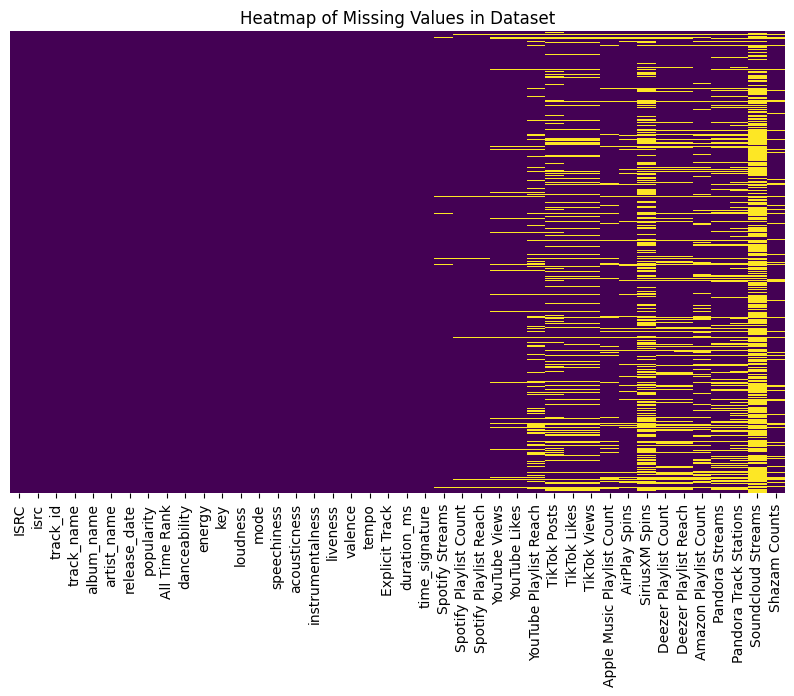

In [ ]:
# Checking for missing values

print("Missing Values:")
print(select_merged_df.isnull().sum())


import seaborn as sns
import matplotlib.pyplot as plt

# Create the heatmap for missing values
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.heatmap(select_merged_df.isnull(), cmap='viridis', cbar=False, yticklabels=False)

# Display the plot
plt.title("Heatmap of Missing Values in Dataset")
plt.show()

Number streams by release date

<ipython-input-7-625e339077d3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[streams_column] = df[streams_column].replace({',': ''}, regex=True)
<ipython-input-7-625e339077d3>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[streams_column] = pd.to_numeric(df[streams_column], errors='coerce')


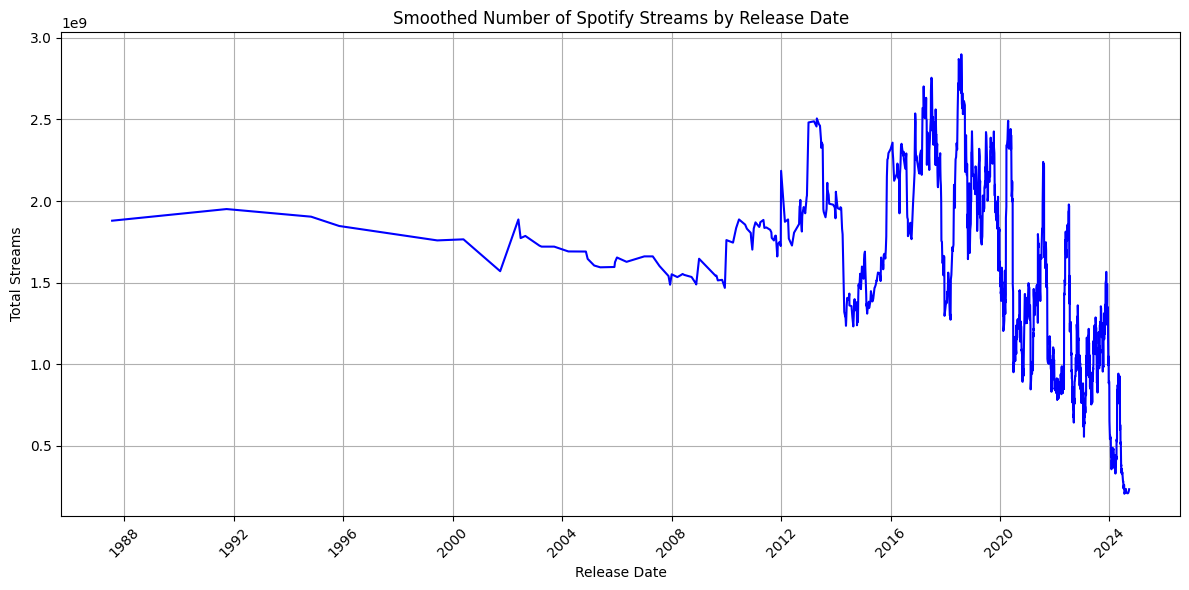

In [ ]:
#streams by release date

import matplotlib.pyplot as plt

# Define the correct DataFrame and column names
df = select_merged_df
streams_column = 'Spotify Streams'

# Ensure 'release_date' is in datetime format, and remove rows with invalid dates
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df = df.dropna(subset=['release_date'])

# Convert streams column to numeric, handling any potential string issues like commas
df[streams_column] = df[streams_column].replace({',': ''}, regex=True)
df[streams_column] = pd.to_numeric(df[streams_column], errors='coerce')

# Group by release date and calculate the sum of streams for each date
streams_by_date = df.groupby('release_date')[streams_column].sum().reset_index()

# apply rolling average of 30 days
streams_by_date['Smoothed Streams'] = streams_by_date[streams_column].rolling(window=30, min_periods=1).mean()

# Plotting the smoothed streams over release dates
plt.figure(figsize=(12, 6))
plt.plot(streams_by_date['release_date'], streams_by_date['Smoothed Streams'], marker='', linestyle='-', color='blue')
plt.title('Smoothed Number of Spotify Streams by Release Date')
plt.xlabel('Release Date')
plt.ylabel('Total Streams')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Distribution of the audio features

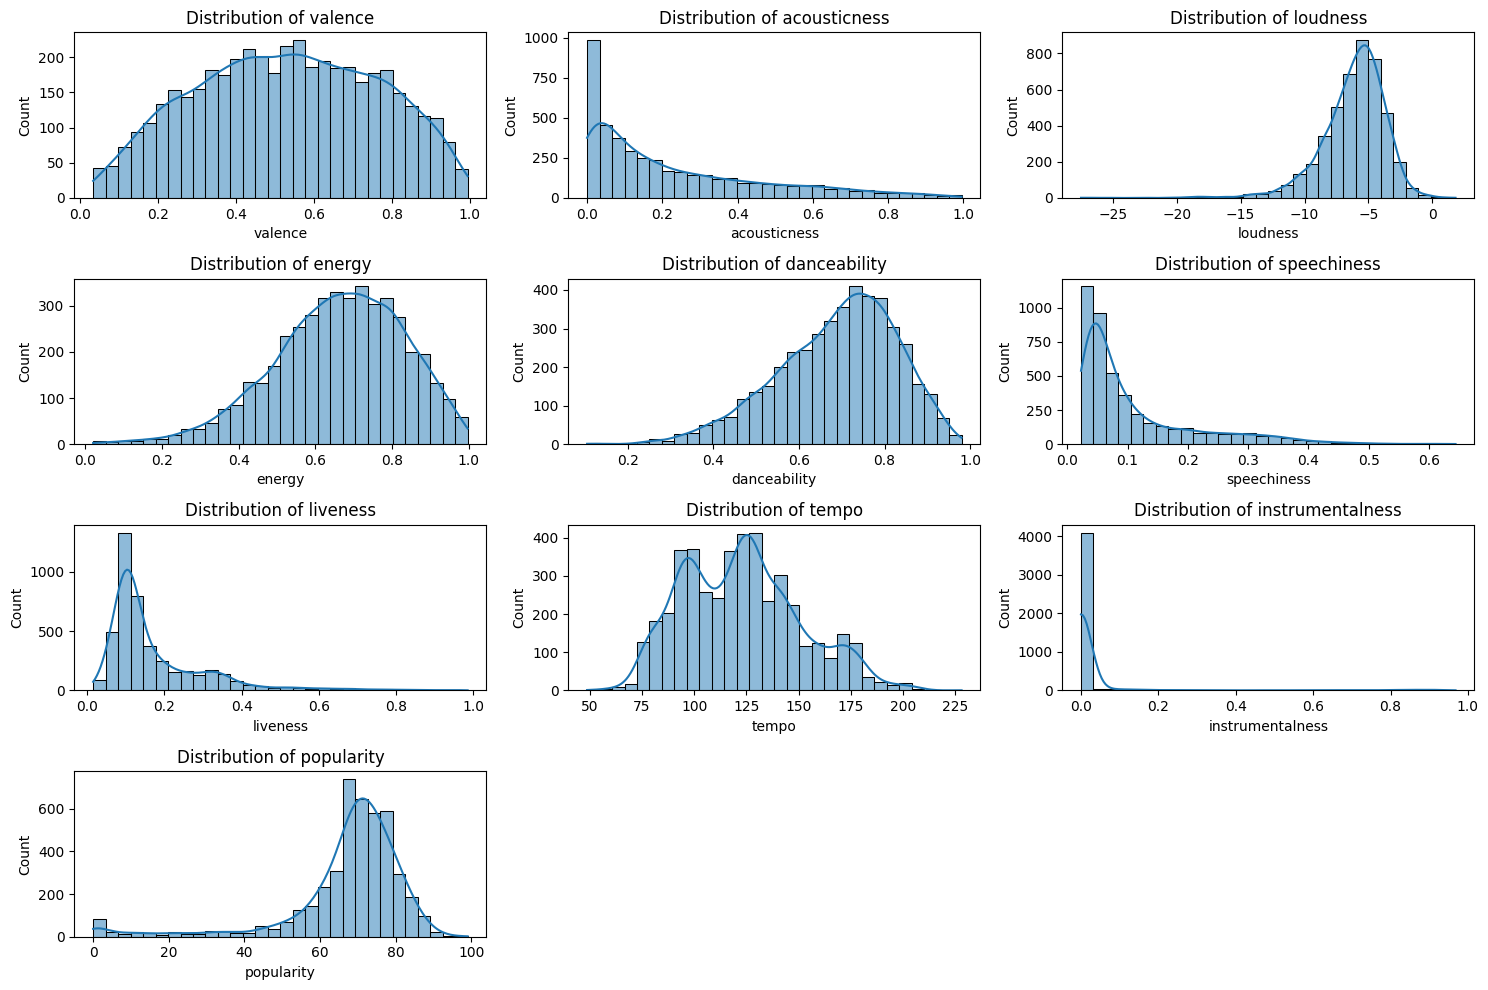

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define your features
audio_features = ['valence', 'acousticness', 'loudness', 'energy', 'danceability',
                  'speechiness', 'liveness', 'tempo', 'instrumentalness', 'popularity']

# Calculate the number of rows needed based on the number of features
num_features = len(audio_features)
num_cols = 3  # Set the number of columns
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate required rows

plt.figure(figsize=(15, 10))

#histograms for each feature
for i, feature in enumerate(audio_features, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(select_merged_df[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()


Corr. between audio features

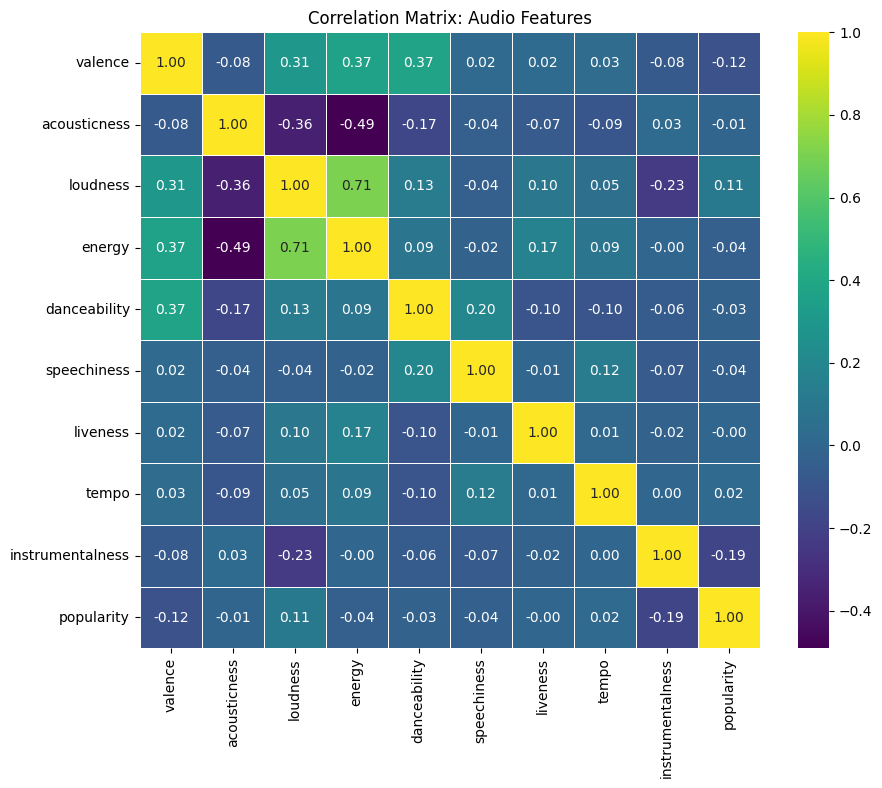

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Define your audio features
audio_features = ['valence', 'acousticness', 'loudness', 'energy', 'danceability',
                  'speechiness', 'liveness', 'tempo', 'instrumentalness', 'popularity']

# Ensure the DataFrame is defined as `select_merged_df`
# Drop rows with missing values in audio features
df_audio_features = select_merged_df[audio_features].dropna()

# Normalize the audio features using MinMaxScaler
scaler = MinMaxScaler()
normalized_audio_features = scaler.fit_transform(df_audio_features)

# Assuming your DataFrame is called `select_merged_df`
corr_data = df_audio_features  # Only use audio features for correlation

# Calculate the correlation matrix for audio features
correlation_matrix = corr_data.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix: Audio Features")
plt.show()



##PCA Clustering

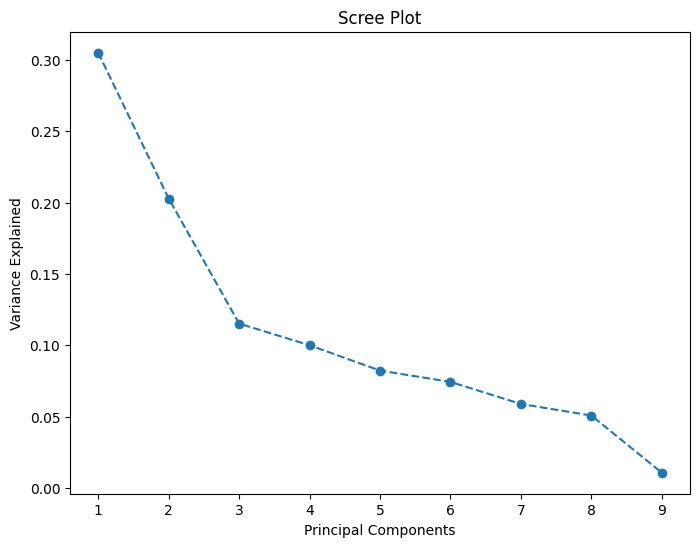

PCA Loadings:
                       PC1       PC2       PC3       PC4       PC5       PC6  \
valence           0.590656  0.700074 -0.100361  0.069339  0.075423 -0.053884   
acousticness     -0.586151  0.668216 -0.100972  0.184043 -0.085236  0.160150   
loudness          0.182482 -0.031864 -0.098317  0.051378 -0.168991  0.032912   
energy            0.453300 -0.125658 -0.290977  0.190855 -0.098533  0.293990   
danceability      0.239894  0.189827  0.447227 -0.411105  0.140128 -0.086408   
speechiness       0.045229  0.008983  0.782964  0.241231 -0.060425  0.454993   
liveness          0.053063 -0.053696 -0.171747  0.176777 -0.292149  0.593145   
tempo             0.060157 -0.074676  0.135533  0.814715  0.205923 -0.406343   
instrumentalness -0.052371 -0.044761 -0.156484 -0.006711  0.893162  0.390531   

                       PC7       PC8       PC9  
valence           0.079554 -0.361989  0.013583  
acousticness     -0.177764  0.317744 -0.019322  
loudness         -0.202682  0.222825  

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA



# Select the relevant audio features
audio_features = ['valence', 'acousticness', 'loudness', 'energy', 'danceability',
                  'speechiness', 'liveness', 'tempo', 'instrumentalness']

# Drop rows with missing values in audio features
df_audio_features = select_merged_df[audio_features].dropna()

# Normalize the audio features using MinMaxScaler
scaler = MinMaxScaler()
normalized_audio_features = scaler.fit_transform(df_audio_features)

# Perform PCA to understand feature groupings
pca = PCA()
pca_result = pca.fit_transform(normalized_audio_features)


# Scree Plot: Explained Variance of Each Principal Component
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.show()

# Analyze the loadings to determine which features are grouped together
loadings = pd.DataFrame(pca.components_.T, index=audio_features, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

# Show the loadings to inspect how features load onto principal components
print("PCA Loadings:")
print(loadings)



Create different track moods by combining audio features based on PC mappings

In [20]:
import pandas as pd
select_merged_df = pd.read_csv('working_Streaming_Spotify_data.csv', encoding='ISO-8859-1')

# Based on the PCA loadings, I created feature groupings for different moods.

df = select_merged_df


df['energetic_mood'] = (df['valence'] + df['energy'] + df['danceability']) / 3


df['calm_mood'] =  (df['valence'] + df['acousticness']+ (1 - df['energy'])) / 3


df['speech_mood'] = (df['danceability'] + df['speechiness'] + df['tempo']) / 3

In [3]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# List of mood columns to scale
mood_columns = ['energetic_mood', 'calm_mood', 'speech_mood']

# Apply Min-Max Scaling to the mood columns
df[mood_columns] = scaler.fit_transform(df[mood_columns])

# normalize the scaled moods so they sum to 100%
# Calculate the total mood score for each song
df['mood_total'] = df[mood_columns].sum(axis=1)

# Normalize each mood score by dividing by the total and multiplying by 100 to get percentages
for mood in mood_columns:
    df[mood] = (df[mood] / df['mood_total']) * 100

# Drop the mood_total column as it's no longer needed
df_mood = df.drop(columns=['mood_total'])

# Preview the normalized mood columns
print(df_mood.head())

           ISRC          isrc                track_id  \
0  QM24S2402528  QM24S2402528  5AJ9hqTS2wcFQCELCFRO7A   
1  USUG12400910  USUG12400910  6AI3ezQ4o3HUoP6Dhudph3   
2  QZJ842400387  QZJ842400387  2GxrNKugF82CnoRFbQfzPf   
3  USSM12209777  USSM12209777  7DSAEUvxU8FajXtRloy8M0   
4  USUG12403398  USUG12403398  2HYFX63wP3otVIvopRS99Z   

                   track_name                  album_name     artist_name  \
0         MILLION DOLLAR BABY         MILLION DOLLAR BABY   Tommy Richman   
1                 Not Like Us                 Not Like Us  Kendrick Lamar   
2  i like the way you kiss me  i like the way you kiss me         Artemas   
3                     Flowers     Endless Summer Vacation     Miley Cyrus   
4                     Houdini                     Houdini          Eminem   

  release_date  popularity All Time Rank  danceability  ...  \
0   2024-04-26          93             1         0.852  ...   
1   2024-05-04          93             2         0.898  ...   
2   2

Explore top songs with dominant moods in each mood group

In [4]:
import pandas as pd

# Filter for songs with popularity > 80
songs_filtered = df_mood[df_mood['popularity'] > 80]

# Function to get the top N popular songs where the selected mood has the highest value
def get_top_songs_by_mood(df, mood_column, top_n=5):
    # Ensure the selected mood is the highest compared to other moods
    mood_columns = ['energetic_mood', 'calm_mood', 'speech_mood']

    # Filter to get only the songs where the selected mood is the highest
    df_filtered = df[df[mood_column] == df[mood_columns].max(axis=1)]

    # Sort by popularity and get top N songs
    return df_filtered.sort_values(by='popularity', ascending=False).head(top_n)

# Get top 5 songs for each mood
top_energetic_songs = get_top_songs_by_mood(songs_filtered, 'energetic_mood', top_n=5)
top_calm_songs = get_top_songs_by_mood(songs_filtered, 'calm_mood', top_n=5)
top_speech_songs = get_top_songs_by_mood(songs_filtered, 'speech_mood', top_n=5)


# Combine the results for easier viewing
top_songs = pd.concat([top_energetic_songs, top_calm_songs, top_speech_songs])

# Display relevant information: track name, artist, popularity, and mood scores
top_songs_filtered = top_songs[['track_name', 'artist_name', 'popularity', 'energetic_mood', 'calm_mood', 'speech_mood']]

# Show the resulting dataframe
print(top_songs_filtered)

                      track_name        artist_name  popularity  \
39            BIRDS OF A FEATHER      Billie Eilish          99   
21                      Espresso  Sabrina Carpenter          97   
351             Good Luck, Babe!      Chappell Roan          97   
44          Please Please Please  Sabrina Carpenter          96   
0            MILLION DOLLAR BABY      Tommy Richman          93   
330                 Stick Season         Noah Kahan          89   
4064         When I Was Your Man         Bruno Mars          89   
43         My Love Mine All Mine             Mitski          89   
1778                Another Love          Tom Odell          88   
2107               Night Changes      One Direction          88   
437                 Cruel Summer       Taylor Swift          92   
347                   WILDFLOWER      Billie Eilish          91   
36                  Lose Control        Teddy Swims          91   
119   FE!N (feat. Playboi Carti)       Travis Scott          9

Summarize number of songs and some streaming metris in each group

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assign dominant mood based on the highest mood score among the four categories
mood_columns = ['energetic_mood', 'calm_mood', 'speech_mood']

# Create a new column for the dominant mood by finding the highest value among the mood columns
df_mood['dominant_mood'] = df_mood[mood_columns].idxmax(axis=1)

#Remove commas and convert 'Spotify Streams' to numeric
df_mood['Spotify Streams'] = df_mood['Spotify Streams'].replace({',': ''}, regex=True)
df_mood['Spotify Streams'] = pd.to_numeric(df_mood['Spotify Streams'], errors='coerce')

# Drop rows where 'Spotify Streams' or 'dominant_mood' are missing
df_mood_cleaned = df_mood.dropna(subset=['popularity', 'Spotify Streams', 'dominant_mood'])

# Step 3: Group songs by their dominant mood and evaluate total and average streams
mood_avg_spotify_stats = df_mood_cleaned.groupby('dominant_mood').agg({
    'popularity': ['mean'],
    'Spotify Streams': ['sum', 'mean', 'count'],
}).reset_index()

# Rename the columns for clarity
mood_avg_spotify_stats.columns = ['Mood', 'Average Popularity', 'Total Streams', 'Average Streams', 'Number of Songs']

# Show the aggregated streaming totals by mood
print(mood_avg_spotify_stats)

             Mood  Average Popularity  Total Streams  Average Streams  \
0       calm_mood           68.304985   1.610584e+11     4.723121e+08   
1  energetic_mood           67.357585   1.470962e+12     4.332731e+08   
2     speech_mood           69.263240   3.080715e+11     4.798622e+08   

   Number of Songs  
0              341  
1             3395  
2              642  


## K-Means

In [22]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

df = select_merged_df

# Select the audio features you want to include in the clustering
features = ['valence', 'energy', 'danceability', 'loudness', 'speechiness',
            'acousticness', 'tempo']

# Standardize the features to have mean=0 and standard deviation=1
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

# Convert the scaled features back into a DataFrame for easier handling
scaled_df = pd.DataFrame(scaled_features, columns=features)


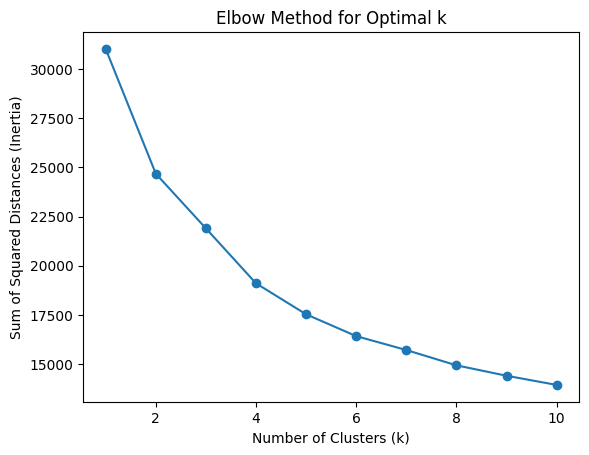

In [23]:

sse = []
k_range = range(1, 11)  # I will try 1 to 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    sse.append(kmeans.inertia_)  # Inertia is sum of squared distances to cluster center

# Plot the results to visualize the Elbow Method
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.show()


In [24]:
# Set the optimal number of clusters (based on the Elbow method)
optimal_k = 3

# Run K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_df)

# Assign cluster labels to the original dataframe
df['cluster'] = kmeans.labels_

# Preview the clusters
df[['cluster'] + features].head()

,cluster,valence,energy,danceability,loudness,speechiness,acousticness,tempo
0,0,0.919,0.697,0.852,-5.520,0.0439,0.097300,138.029
1,0,0.214,0.472,0.898,-7.001,0.0776,0.010700,101.061
2,0,0.747,0.946,0.599,-4.263,0.0447,0.000938,151.647
3,0,0.632,0.691,0.706,-4.775,0.0633,0.058400,118.048
4,0,0.889,0.887,0.936,-2.760,0.0683,0.029200,127.003


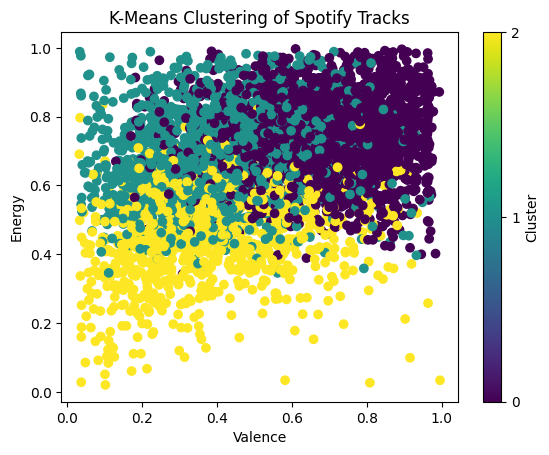

In [25]:
from matplotlib.colors import ListedColormap
import seaborn as sns

# Visualize the clusters using two key features (e.g., valence and energy)

# Define a discrete colormap with a distinct color for each cluster
cmap = ListedColormap(sns.color_palette("viridis", n_colors=optimal_k))

plt.scatter(df['valence'], df['energy'], c=df['cluster'], cmap='viridis', marker='o')
plt.xlabel('Valence')
plt.ylabel('Energy')
plt.title('K-Means Clustering of Spotify Tracks')
plt.colorbar(ticks=range(optimal_k), label='Cluster')
plt.show()

In [26]:
# Get the mean feature values for each cluster
cluster_means = df.groupby('cluster')[features].mean()

# Display the mean feature values for each cluster
print(cluster_means)

# Count the number of songs in each cluster
cluster_counts = df['cluster'].value_counts()

# Display the count of songs per cluster
print("Number of Songs in Each Cluster:")
print(cluster_counts)

          valence    energy  danceability  loudness  speechiness  \
cluster                                                            
0        0.677515  0.741710      0.755774 -5.028636     0.096299   
1        0.411663  0.685217      0.637616 -5.960954     0.144087   
2        0.385554  0.454210      0.626796 -8.911593     0.093722   

         acousticness       tempo  
cluster                            
0            0.175010  113.506706  
1            0.123163  143.656699  
2            0.514551  111.537578  
Number of Songs in Each Cluster:
cluster
0    2070
1    1403
2     960
Name: count, dtype: int64


In [29]:
from IPython.display import display
import pandas as pd

# List of streaming metric columns
streaming_columns = ['popularity', 'Spotify Streams', 'YouTube Views', 'TikTok Views',
                     'TikTok Likes', 'AirPlay Spins', 'Pandora Streams', 'Shazam Counts']

# Remove commas and convert all streaming metrics to numeric
df[streaming_columns] = df[streaming_columns].apply(lambda x: pd.to_numeric(x.replace({',': ''}, regex=True), errors='coerce'))

# Fill missing values with the mean for each streaming metric
df[streaming_columns] = df[streaming_columns].apply(lambda x: x.fillna(x.mean()))

# Calculate the mean number of streams, views, and counts for each cluster
cluster_streams = df.groupby('cluster')[streaming_columns].mean()

# Round to 2 decimal points
cluster_streams = cluster_streams.round(2)

# Display the dataframe as a table
display(cluster_streams)



,popularity,Spotify Streams,YouTube Views,TikTok Views,TikTok Likes,AirPlay Spins,Pandora Streams,Shazam Counts
cluster,,,,,,,,
0,66.29,4.340933e+08,4.269865e+08,1.152703e+09,1.088222e+08,58788.37,81490367.12,2425219.44
1,67.75,4.360329e+08,3.483851e+08,8.815648e+08,8.719397e+07,55710.21,84285079.84,2330646.73
2,67.29,4.730601e+08,3.574814e+08,1.447366e+09,1.471401e+08,46235.87,93355516.95,2682432.03
